# Image Classification of an American Sign Language Dataset

In this section, we will perform the data preparation, model creation, and model training steps

## Objectives

* Prepare image data for training
* Create and compile a simple model for image classification
* Train an image classification model and observe the results

# American Sign Language Dataset

The American Sign Language alphabet contains 26 letters. Two of those letters (j and z) require movement, so they are not included in the training dataset.

<img src="../images/asl.png" style="width: 600px;">

### Kaggle


This dataset is available from the website Kaggle, which is a fantastic place to find datasets and other deep learning resources. In addition to providing resources like datasets and "kernels" that are like these notebooks, Kaggle hosts competitions that you can take part in, competing with others in training highly accurate models.

If you're looking to practice or see examples of many deep learning projects, Kaggle is a great site to visit.

### Loading the Data

The sign language dataset is in [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) (Comma Separated Values) format, the same data structure behind Microsoft Excel and Google Sheets. It is a grid of rows and columns with labels at the top, as seen in the [train](data/asl_data/sign_mnist_train.csv) and [valid](data/asl_data/sign_mnist_valid.csv) datasets (they may take a moment to load).

To load and work with the data, we'll be using a library called [Pandas](https://pandas.pydata.org/), which is a highly performant tool for loading and manipulating data. We'll read the CSV files into a format called a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [1]:
import pandas as pd

Pandas has a read_csv method that expects a csv file, and returns a DataFrame:

In [2]:
train_df = pd.read_csv("../data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("../data/asl_data/sign_mnist_valid.csv")

### Exploring the Data

Let's take a look at our data. We can use the [head](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) method to print the first few rows of the DataFrame. Each row is an image which has a `label` column, and also, 784 values representing each pixel value in the image, just like with the MNIST dataset. Note that the labels currently are numerical values, not letters of the alphabet:

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Extracting the Labels

we would like to store our training and validation labels in `y_train` and `y_valid` variables. Here we create those variables and then delete the labels from our original dataframes, where they are no longer needed:

In [4]:
y_train = train_df["label"]
y_valid = valid_df["label"]
del train_df["label"]
del valid_df["label"]

### Extracting the Images

we would like to store our training and validation images in `x_train` and `x_valid` variables. Here we create those variables:

In [5]:
x_train = train_df.values
x_valid = valid_df.values

### Summarizing the Training and Validation Data

We now have 27,455 images with 784 pixels each for training...

In [6]:
x_train.shape

(27455, 784)

In [7]:
y_train.shape

(27455,)

For validation, we have 7,172 images...

In [8]:
x_valid.shape

(7172, 784)

In [9]:
y_valid.shape

(7172,)

## Visualizing the Data

To visualize the images, we will again use the matplotlib library. We don't need to worry about the details of this visualization, but if interested, you can learn more about [matplotlib](https://matplotlib.org/) at a later time.

Note that we'll have to reshape the data from its current 1D shape of 784 pixels, to a 2D shape of 28x28 pixels to make sense of the image:

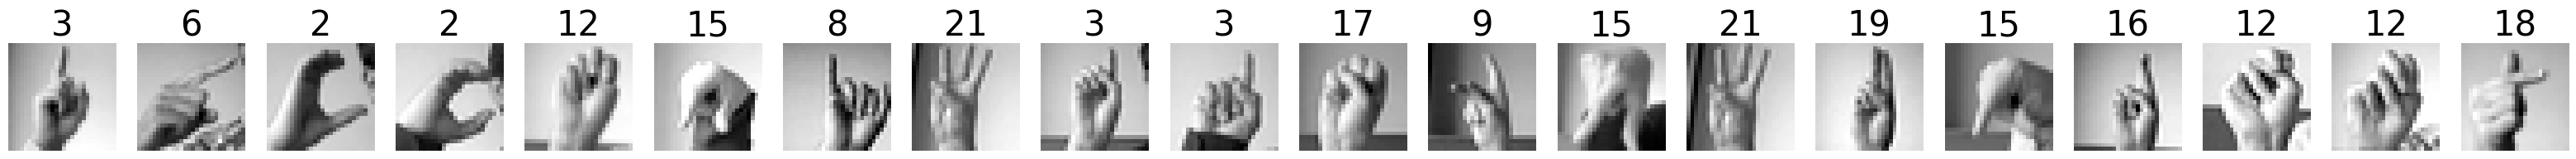

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))

num_images = 20
for i in range(num_images):
    row = x_train[i]
    label = y_train[i]

    image = row.reshape(28, 28)
    plt.subplot(1, num_images, i + 1)
    plt.title(label, fontdict={'fontsize': 30})
    plt.axis("off")
    plt.imshow(image, cmap='gray')

## Normalize the Image Data

we are going to normalize the image data, meaning that their pixel values, instead of being between 0 and 255 as they are currently:

In [11]:
x_train.min()

0

In [12]:
x_train.max()

255

...should be floating point values between 0 and 1. Use the following cell to work. If you get stuck, look at the solution below.

In [13]:
# Normalize x_train and y_train
x_train = x_train / 255
x_valid = x_valid / 255

In [14]:
x_train.min()

0.0

In [15]:
x_train.max()

1.0

## Categorize the Labels

we are going to categorically encode the labels. Recall that we can use the [keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) method to accomplish this by passing it the values to encode, and, the number of categories to encode it into.

In [16]:
import tensorflow.keras as keras

NUM_CLASSES = 24

2025-03-23 08:08:59.558452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-23 08:08:59.558576: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
# Categorically encode y_train and y_valid.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)

## Build the Model

The data is all prepared, we have normalized images for training and validation, as well as categorically encoded labels for training and validation.

we are going to build a sequential model. build a model that:
* Has a dense input layer. This layer should contain 512 neurons, use the `relu` activation function, and expect input images with a shape of `(784,)`
* Has a second dense layer with 512 neurons which uses the `relu` activation function
* Has a dense output layer with neurons equal to the number of classes, using the `softmax` activation function

Do your work in the cell below, creating a `model` variable to store the model. We've imported the Keras [Sequental](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model class and [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer class to get you started. 

In [18]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [19]:
# build a model following the guidelines above.
model = Sequential()
model.add(Dense(units=512, activation="relu", input_shape=(784,)))
model.add(Dense(units=512, activation="relu"))
model.add(Dense(units=NUM_CLASSES, activation="softmax"))

2025-03-23 08:10:13.733574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-23 08:10:13.733632: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-23 08:10:13.743530: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-BNBMB7Q): /proc/driver/nvidia/version does not exist
2025-03-23 08:10:13.744643: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Summarizing the Model

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 24)                12312     
Total params: 676,888
Trainable params: 676,888
Non-trainable params: 0
_________________________________________________________________


## Compiling the Model

We'll [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#compile) our model, using [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) to reflect the fact that we want to fit into one of many categories, and measuring the accuracy of our model:

In [21]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

## Train the Model

Use the model's `fit` method to train it for 20 epochs using the training and validation images and labels created above:

In [22]:
# Train the model for 20 epochs.
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    verbose=1,
    validation_data=(x_valid, y_valid),
)

2025-03-23 08:12:20.282645: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 86098880 exceeds 10% of free system memory.
2025-03-23 08:12:21.824639: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-03-23 08:12:21.863136: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2112005000 Hz


Epoch 1/20
851/858 [============================>.] - ETA: 0s - loss: 1.9619 - accuracy: 0.3805

2025-03-23 08:12:33.369621: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 22491392 exceeds 10% of free system memory.


858/858 [==============================] - 12s 12ms/step - loss: 1.9560 - accuracy: 0.3822 - val_loss: 1.4987 - val_accuracy: 0.5053
Epoch 2/20
858/858 [==============================] - 7s 8ms/step - loss: 0.9460 - accuracy: 0.6802 - val_loss: 1.5135 - val_accuracy: 0.5883
Epoch 3/20
858/858 [==============================] - 7s 8ms/step - loss: 0.5770 - accuracy: 0.8054 - val_loss: 0.7440 - val_accuracy: 0.7550
Epoch 4/20
858/858 [==============================] - 7s 8ms/step - loss: 0.3859 - accuracy: 0.8787 - val_loss: 1.0235 - val_accuracy: 0.7645
Epoch 5/20
858/858 [==============================] - 11s 13ms/step - loss: 0.3027 - accuracy: 0.9101 - val_loss: 0.7512 - val_accuracy: 0.8101
Epoch 6/20
858/858 [==============================] - 7s 8ms/step - loss: 0.2478 - accuracy: 0.9328 - val_loss: 1.4087 - val_accuracy: 0.7122
Epoch 7/20
858/858 [==============================] - 7s 8ms/step - loss: 0.2232 - accuracy: 0.9427 - val_loss: 2.9763 - val_accuracy: 0.6005
Epoch 8/20
85

### Visualizing the training

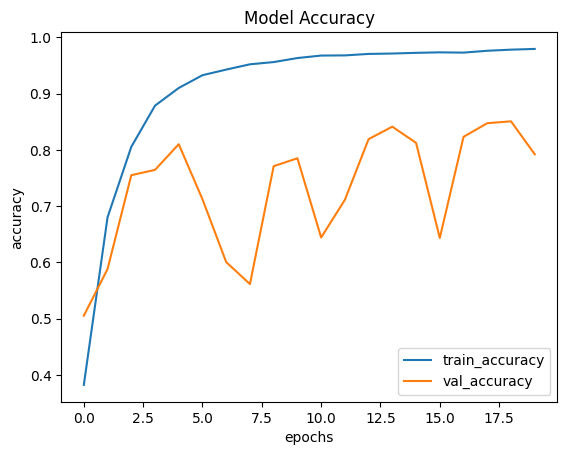

In [23]:
# Ploting the accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.legend(["train_accuracy", "val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

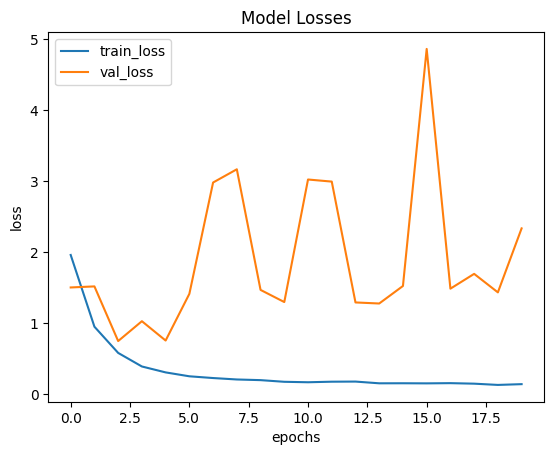

In [24]:
# Ploting the loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Losses")
plt.legend(["train_loss", "val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

We can see that the training accuracy got to a fairly high level, but the validation accuracy was not as high. What happened here?

### Save the Model

In [25]:
model.save("../models/1_sl_basic_model")

2025-03-23 08:15:10.142262: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/1_sl_basic_model/assets


## Summary

This is an example of the model learning to categorize the training data, but performing poorly against new data that it has not been trained on. Essentially, it is memorizing the dataset, but not gaining a robust and general understanding of the problem. This is a common issue called *overfitting*.

In this section you built your own neural network to perform image classification that is quite accurate. Congrats!

At this point we should be getting somewhat familiar with the process of loading data (incuding labels), preparing it, creating a model, and then training the model with prepared data.

### Clear the Memory
Before moving on, please execute the following cell to clear up the GPU memory. 

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}